In [2]:
IMG_SIZE = 224
BATCH_SIZE = 32

RAW_DIR = "/kaggle/input/cats-data/cat_data/Cats"

print("IMG_SIZE:", IMG_SIZE)
print("BATCH_SIZE:", BATCH_SIZE)
print("RAW_DIR exists:", RAW_DIR)


IMG_SIZE: 224
BATCH_SIZE: 32
RAW_DIR exists: /kaggle/input/cats-data/cat_data/Cats


In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models


2025-12-24 14:17:12.876074: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766585833.044818      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766585833.092881      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [4]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=25,
    zoom_range=0.2,
    horizontal_flip=True
)

train_gen = datagen.flow_from_directory(
    RAW_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    RAW_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

print("Classes:", train_gen.class_indices)


Found 190 images belonging to 4 classes.
Found 47 images belonging to 4 classes.
Classes: {'Bibers': 0, 'Caramel': 1, 'Putchi': 2, 'Smokey': 3}


In [5]:
base_model = MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(train_gen.num_classes, activation="softmax")(x)

model = models.Model(inputs, outputs)
model.summary()


I0000 00:00:1766585849.159121      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1766585849.159904      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,586,948 (9.87 MB)

 Trainable params: 328,964 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [6]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1766585864.093621     122 service.cc:148] XLA service 0x7b3b9c012280 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1766585864.094441     122 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1766585864.094474     122 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1766585865.100540     122 cuda_dnn.cc:529] Loaded cuDNN version 90300


1/6 ━━━━━━━━━━━━━━━━━━━━ 1:06 13s/step - accuracy: 0.2188 - loss: 1.7541

I0000 00:00:1766585869.870948     122 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6/6 ━━━━━━━━━━━━━━━━━━━━ 46s 6s/step - accuracy: 0.3581 - loss: 1.7672 - val_accuracy: 0.8085 - val_loss: 0.7072
Epoch 2/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.5508 - loss: 1.0898 - val_accuracy: 0.7447 - val_loss: 0.5676
Epoch 3/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.7391 - loss: 0.6252 - val_accuracy: 0.8085 - val_loss: 0.4273
Epoch 4/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.8665 - loss: 0.4408 - val_accuracy: 0.9149 - val_loss: 0.2450
Epoch 5/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.8519 - loss: 0.4535 - val_accuracy: 0.8298 - val_loss: 0.3974
Epoch 6/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.8724 - loss: 0.3130 - val_accuracy: 0.9149 - val_loss: 0.2325
Epoch 7/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.9217 - loss: 0.2249 - val_accuracy: 0.8723 - val_loss: 0.2721
Epoch 8/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.9142 - loss: 0.2132 - val_accuracy: 0.8936 - val_loss: 0.2755
Epoch 9/15
6/6 ━━━━

In [7]:
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5
)


Epoch 1/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - accuracy: 0.7914 - loss: 0.4940 - val_accuracy: 0.9149 - val_loss: 0.2246
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.8408 - loss: 0.4011 - val_accuracy: 0.8936 - val_loss: 0.2764
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.8751 - loss: 0.3472 - val_accuracy: 0.9149 - val_loss: 0.2046
Epoch 4/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.9236 - loss: 0.2436 - val_accuracy: 0.9362 - val_loss: 0.1916
Epoch 5/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.8627 - loss: 0.3785 - val_accuracy: 0.9574 - val_loss: 0.1813


In [8]:
model.save("cat_identity_mobilenetv2.keras")
print("Model saved successfully")

✅ Model saved successfully


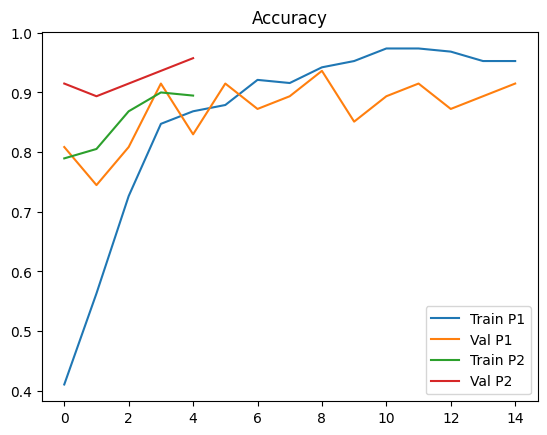

In [9]:
plt.plot(history_1.history["accuracy"], label="Train P1")
plt.plot(history_1.history["val_accuracy"], label="Val P1")
plt.plot(history_2.history["accuracy"], label="Train P2")
plt.plot(history_2.history["val_accuracy"], label="Val P2")
plt.legend()
plt.title("Accuracy")
plt.show()


Class mapping: {0: 'Bibers', 1: 'Caramel', 2: 'Putchi', 3: 'Smokey'}


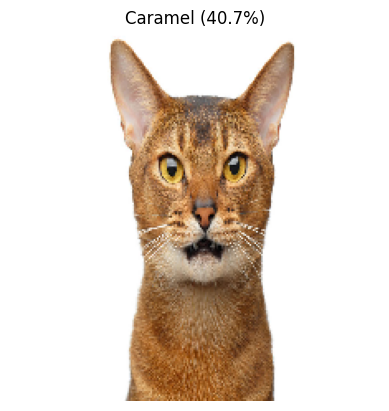

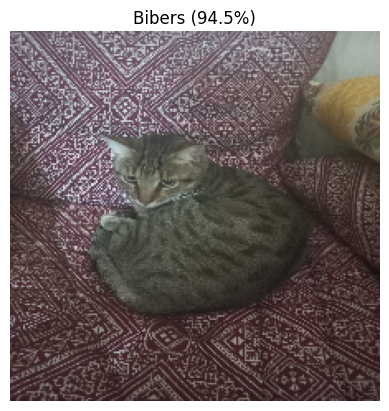

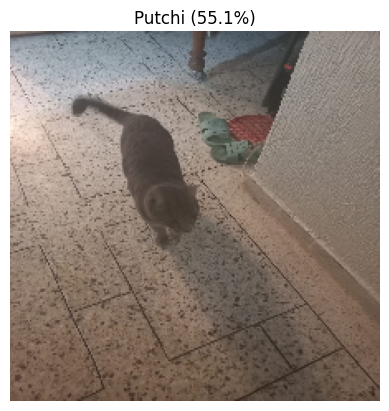

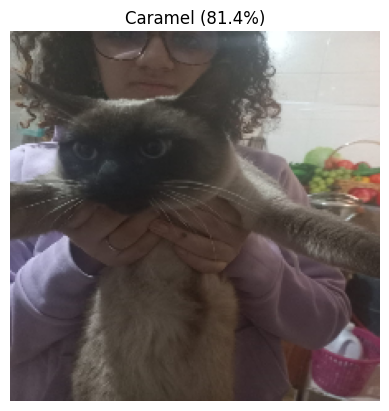

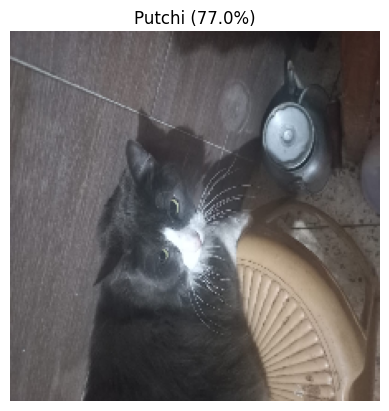

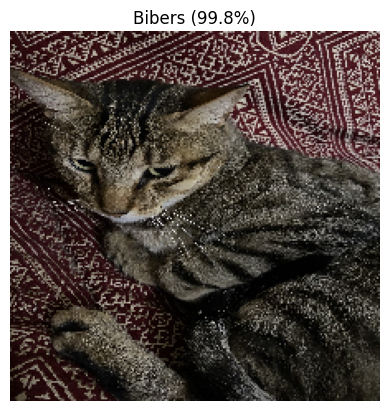

In [11]:
class_names = sorted([
    d for d in os.listdir(RAW_DIR)
    if os.path.isdir(os.path.join(RAW_DIR, d))
])
idx_to_class = {i: name for i, name in enumerate(class_names)}
print("Class mapping:", idx_to_class)

def predict_image(img_path):
    img = tf.keras.utils.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    arr = tf.keras.utils.img_to_array(img) / 255.0
    arr = np.expand_dims(arr, axis=0)

    preds = model.predict(arr, verbose=0)[0]
    idx = np.argmax(preds)

    plt.imshow(img)
    plt.title(f"{idx_to_class[idx]} ({preds[idx]*100:.1f}%)")
    plt.axis("off")
    plt.show()


predict_image("/kaggle/input/test-cat/cat.jpg")
predict_image("/kaggle/input/test-cat3/cat3.jpeg")
predict_image("/kaggle/input/test-cat3/cat4.jpeg")
predict_image("/kaggle/input/test-cat3/cat5.jpeg")
predict_image("/kaggle/input/test-cat3/cat6.jpeg")
predict_image("/kaggle/input/cats-data/cat_data/Cats/Bibers/IMG_0837.jpg")



